In [17]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import igraph as ig
import os
import yaml
from os.path import join
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.stats import entropy
from scipy import stats
from functools import reduce
import sys
sys.path.insert(1, '..')
from utils import *
from collections import Counter
import geopandas as gpd
import matplotlib.ticker as ticker
import geopandas as gpd
import json

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [18]:
FIG_SAVE_DIR = join('..', '..', 'figures')
RESULT_SAVE_DIR = join('..', '..', 'results')

In [19]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']

AREA_NAME = 'NYC'

In [20]:
borough_df = gpd.read_file(join(pwd, 'util_datasets', 'NYC', 'NYC-borough.geojson'))

In [21]:
poi_df = pd.read_csv(join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-POI-INFO.csv'))
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.longitude, poi_df.latitude))

In [22]:
merged = gpd.sjoin(gdf, borough_df, how='left', op='within')

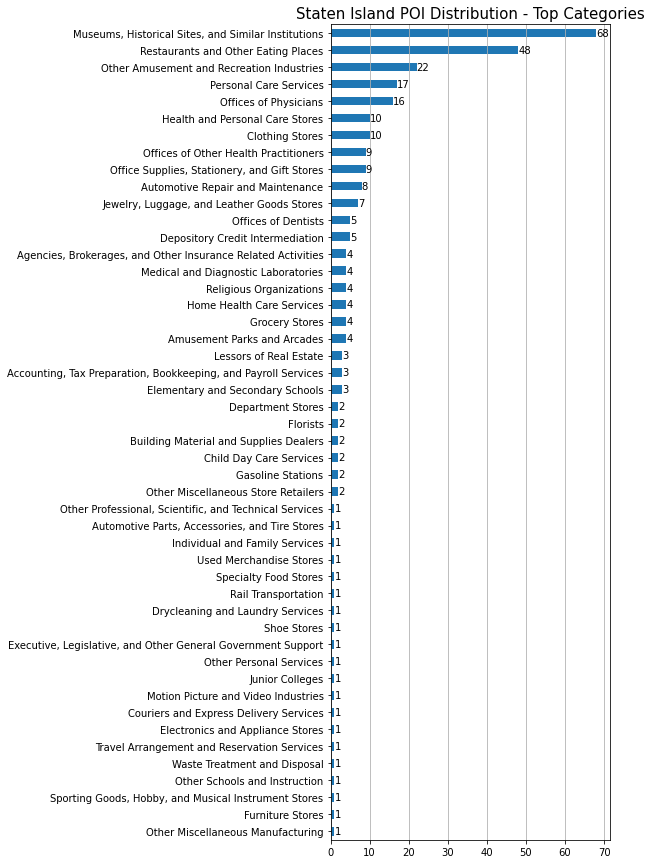

In [23]:
sl_poi = merged[merged['boro_name'] == 'Staten Island']['top_category'].value_counts(normalize=False)[::-1]
ax = sl_poi.plot.barh(figsize=(5, 15))
ax.grid(axis='x')
#ax.set_xlim(0, 75)
ax.set_title('Staten Island POI Distribution - Top Categories', fontsize=15)

for i, val in enumerate(sl_poi):
    ax.text(val, i, str(val), verticalalignment='center')
    
#plt.tight_layout()
plt.savefig(join(FIG_SAVE_DIR, 'nyc-staten-island-poi-dist-topcat.png'), bbox_inches='tight')

In [24]:
PATTERN_DIR = join(pwd, dpath, 'filtered-patterns')

AREA_NAME = 'NYC'
FILTERED_PATTERN_DIR = join(PATTERN_DIR, f'{AREA_NAME}-patterns')
pattern_files = [join(FILTERED_PATTERN_DIR, f) for f in os.listdir(FILTERED_PATTERN_DIR) if f.endswith('csv')]

In [25]:
sl_cbgs = set(pd.read_csv(join(pwd, 'util_datasets', 'staten_island_cbgs.csv'))['cbgs'].astype(np.int64).values)

In [26]:
def check_cbg(visitor_cbgs):
    for cbg in json.loads(visitor_cbgs).keys():
        cbg = np.int64(cbg)
        if cbg in sl_cbgs:
            return True
    return False

In [27]:
sg_ids = []
for pattern_file in tqdm(pattern_files):
    df = pd.read_csv(pattern_file)
    sl_ind = df['poi_cbg'].isin(sl_cbgs)
    sl_df = df[sl_ind]
    other_df = df[~sl_ind]
    
    sg_id = other_df[other_df['visitor_home_cbgs'].apply(check_cbg)]['safegraph_place_id']
    sg_ids.append(sg_id)

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [02:27<00:00,  1.38s/it]


In [28]:
cat_df = poi_df[['safegraph_place_id', 'top_category', 'sub_category']].set_index('safegraph_place_id')

In [29]:
cats = []
for sg_id in sg_ids:
    cats.append(cat_df.loc[np.intersect1d(cat_df.index, sg_id)]['sub_category'])

In [30]:
[i.value_counts(normalize=False).sort_values(ascending=False)[2:3] for i in cats]

[Limited-Service Restaurants    241
 Name: sub_category, dtype: int64,
 Limited-Service Restaurants    292
 Name: sub_category, dtype: int64,
 Fitness and Recreational Sports Centers    309
 Name: sub_category, dtype: int64,
 Fitness and Recreational Sports Centers    286
 Name: sub_category, dtype: int64,
 Fitness and Recreational Sports Centers    290
 Name: sub_category, dtype: int64,
 Fitness and Recreational Sports Centers    308
 Name: sub_category, dtype: int64,
 Fitness and Recreational Sports Centers    283
 Name: sub_category, dtype: int64,
 Fitness and Recreational Sports Centers    272
 Name: sub_category, dtype: int64,
 Limited-Service Restaurants    286
 Name: sub_category, dtype: int64,
 Fitness and Recreational Sports Centers    304
 Name: sub_category, dtype: int64,
 Fitness and Recreational Sports Centers    299
 Name: sub_category, dtype: int64,
 Fitness and Recreational Sports Centers    274
 Name: sub_category, dtype: int64,
 Fitness and Recreational Sports Centers